# PDFA Hyperparameter Study
by Kandai Watanabe (kandai.watanabe@colorado.edu / kandai.wata@gmail.com)

or reach me out on github (https://github.com/watakandai)

Change up to the main repo directory 

In [1]:
import os
os.chdir(os.path.join('..', '..'))

In [2]:
%load_ext autoreload
%autoreload 2
import gym
from IPython.display import Video
from sklearn.model_selection import train_test_split
import itertools
import os
import numpy as np
from tqdm.autonotebook import tqdm
from joblib import Parallel, delayed, wrap_non_picklable_objects
import multiprocessing
import copy

from wombats.systems import (StaticMinigridTSWrapper,
                             LavaComparison_noDryingOff)
from wombats.automaton import active_automata
from wombats.automaton import MinigridTransitionSystem
from wombats.automaton import Automaton
from wombats.learning import FlexfringeInterface
from wombats.utils import get_experiment_paths

# setting all paths
EXPERIMENT_NAME = 'pdfa_hyperparameter_study'

path_data = get_experiment_paths(EXPERIMENT_NAME)
EXPERIMENT_DIR = path_data['EXPERIMENT_DIR']
PDFA_MODEL_CONFIG_FILE = path_data['PDFA_MODEL_CONFIG_FILE']
LEARNER_DATA_DIR = path_data['LEARNER_DATA_DIR']
LEARNING_TRAIN_DATA_REL_FILEPATH = path_data['LEARNING_TRAIN_DATA_REL_FILEPATH']
LEARNING_TEST_DATA_REL_FILEPATH = path_data['LEARNING_TEST_DATA_REL_FILEPATH']

# reset the kernel's Automata class' experimental directory for all created
# Automaton objects.
#
# If you autoreload any code having to do with the automaton, then you will
# need to re-run this cell to get the right automaton data path back, as the
# reload will reset the base Automaton class' automata_data_dir property
Automaton.automata_data_dir = os.path.join(EXPERIMENT_DIR)

/Users/kandai/.pyenv/versions/anaconda3-5.3.0/envs/wombats/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  if __name__ == '__main__':


In [3]:
path_data

{'EXPERIMENT_DIR': 'experiments/pdfa_hyperparameter_study',
 'PDFA_MODEL_CONFIG_FILE': 'wombats/config/PDFA_pdfa_hyperparameter_study.yaml',
 'TS_MODEL_CONFIG_FILE': 'wombats/config/TS_pdfa_hyperparameter_study.yaml',
 'GYM_MONITOR_LOG_DIR': 'experiments/pdfa_hyperparameter_study/minigrid_env_logs',
 'LEARNER_DATA_DIR': 'experiments/pdfa_hyperparameter_study/flexfringe_data',
 'LEARNING_TRAIN_DATA_REL_FILEPATH': 'flexfringe_data/pdfa_hyperparameter_study_train',
 'LEARNING_TEST_DATA_REL_FILEPATH': 'flexfringe_data/pdfa_hyperparameter_study_test'}

## Loading in the Specification

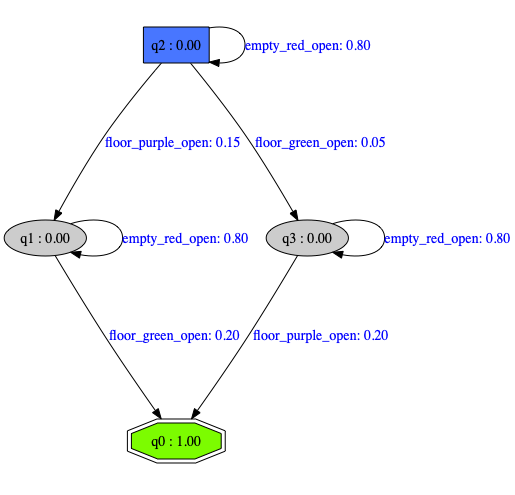

In [4]:
pdfa_specification = active_automata.get(automaton_type='PDFA',
                                         graph_data=PDFA_MODEL_CONFIG_FILE)
pdfa_specification.draw('_'.join([EXPERIMENT_NAME, 'PDFA']))

In [5]:
MPS, MPS_prob, _ = pdfa_specification.most_probable_string()
print(f'Learned MPS: {MPS}')
print(f'Probability of MPS in PDFA"s Language: {MPS_prob}')


Learned MPS: ['floor_purple_open', 'floor_green_open']
Probability of MPS in PDFA"s Language: 0.03


## Learning the Specification

We will take this specification and learn it using `Flexfringe`

### Creating Training / Test Data

Here, we choose a 90/10 training/test split in our data using N samples fron the target specification.

In [6]:
num_samples = 100
max_trace_length = 20
(traces,
 trace_lengths,
 trace_probs) = pdfa_specification.generate_traces(num_samples, N=max_trace_length)

# create a training-test split for model validation after training 
test_size = 0.1
(traces_train, traces_test,
 traceLengths_train, traceLengths_test,
 trace_probs_train, trace_probs_test) = train_test_split(traces,
                                                         trace_lengths,
                                                         trace_probs,
                                                         test_size=test_size)

# Write learning data to files for inference
train_data_file = pdfa_specification.write_traces_to_file(
    traces_train,
    alphabet_size=pdfa_specification.alphabet_size,
    file=LEARNING_TRAIN_DATA_REL_FILEPATH)
test_data_file = pdfa_specification.write_traces_to_file(
    traces_test,
    alphabet_size=pdfa_specification.alphabet_size,
    file=LEARNING_TEST_DATA_REL_FILEPATH)

In [7]:
print(len(traces_train))
for i, trace in enumerate(traces_train):
    print(i+1, trace)

print("")
print("")
print("")
print("----------")
print(len(traces_test))
for i, trace in enumerate(traces_test):
    print(i+1, trace)

90
1 ['floor_purple_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
2 ['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_purple_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
3 ['empty_red_open', 'floor_purple_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
4 ['empty_red_open', 'empty_red_open', 'floor_purple_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_green_open']
5 ['floor_green_open', 'empty_red_open', 'floor_purple_open']
6 ['empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'empty_red_open', 'floor_purple_open', 'empty_red_open', 'empty_red_open', 'floor_green_op

In [8]:
test_cross_ent, train_cross_ent, target_cross_ent = [], [], []
for trace in traces_test:
    test_cross_ent.append(pdfa_specification.cross_entropy_approx(trace))
for trace in traces_train:
    train_cross_ent.append(pdfa_specification.cross_entropy_approx(trace))

# averaging over all examples
test_cross_ent = np.mean(test_cross_ent)
train_cross_ent = np.mean(train_cross_ent)

print(f"Mean Test Approximate Cross-Entropy of Specified Model: {test_cross_ent}")
print(f"Mean Training Approximate Cross-Entropy of Specified Model: {train_cross_ent}")

test_perplexity = pow(2, test_cross_ent)
train_perplexity = pow(2, train_cross_ent)
    
print(f"Mean Test Approximate Perplexity of Specified Model: {test_perplexity}")
print(f"Mean Training Approximate Perplexity of Specified Model: {train_perplexity}")

test_cross_ent = pdfa_specification.cross_entropy(traces_test, trace_probs_test)
train_cross_ent = pdfa_specification.cross_entropy(traces_train, trace_probs_train)

print(f"Test Cross-Entropy of Specified Model: {test_cross_ent}")
print(f"Training Cross-Entropy of Specified Model: {train_cross_ent}")

test_perplexity = pdfa_specification.perplexity(traces_test, trace_probs_test)
train_perplexity = pdfa_specification.perplexity(traces_train, trace_probs_train)

print(f"Test Perplexity of Specified Model: {test_perplexity}")
print(f"Training Perplexity of Specified Model: {train_perplexity}")

# This simply checks if the next symbol estimated at each step matches with the measured symbol for all steps for all samples.
# Therefore, if a trace takes longest/shortest path, it may not match with the estimate. 
# Thus, this measurement is not reliable.
print(pdfa_specification.predictive_accuracy(test_traces=traces_test))
print(pdfa_specification.predictive_accuracy(test_traces=traces_test))

test_score = pdfa_specification.mdi_score(traces_test)
train_score = pdfa_specification.mdi_score(traces_train)

print(f"Test MDI Score of Specified Model: {test_score}")
print(f"Training MDI Score  of Specified Model: {train_score}")

Mean Test Approximate Cross-Entropy of Specified Model: 1.0237214812414217
Mean Training Approximate Cross-Entropy of Specified Model: 1.0526233354807386
Mean Test Approximate Perplexity of Specified Model: 2.0331567986401504
Mean Training Approximate Perplexity of Specified Model: 2.0742982364518747
Test Cross-Entropy of Specified Model: 0.4794679885805545
Training Cross-Entropy of Specified Model: 4.685086002498934
Test Perplexity of Specified Model: 1.3942294324069184
Training Perplexity of Specified Model: 25.72476517279883
0.1
0.4
Test MDI Score of Specified Model: 1.9630661806147311
Training MDI Score  of Specified Model: 2.823803501331485


    ### Learning with `Flexfringe`

We are going to use the wombats wrapper to learn the specification.

In [30]:
flexfringe = FlexfringeInterface(output_directory=LEARNER_DATA_DIR)
flexfringe.infer_model(get_help=True)
flexfringe.num_training_examples = len(traces_train)

no learning options specified, printing tool help:
welcome, running git commit c8fad5bd3b0c0dad0e28ec7606f20a7fcf975071 with: dfasat/flexfringe --help  
Usage: flexfringe [OPTIONS]* [input dfa file]
      --version                   Display version information
  -V, --debug=integer             Debug mode and verbosity evel
  -o, --output-dir=string         Relative path for output files with trailing
                                  /, default: "./".
  -h, --heuristic-name=string     Name of the merge heurstic to use; default
                                  count_driven. Use any heuristic in the
                                  evaluation directory. It is often beneficial
                                  to write your own, as heuristics are very
                                  application specific.
  -d, --data-name=string          Name of the merge data class to use; default
                                  count_data. Use any heuristic in the
                                 

Here, we are going to do a grid search over all possible choices of hyperparameters to try to identify a good way to programatically set the hyperparameters:

In [31]:
NUM_P_VALUES = 100
P_VALUES = [str(i / NUM_P_VALUES) for i in range(0, NUM_P_VALUES, 5)]
# P_VALUES = ['0.05']

L_VAL = [0,1,5,10]
# L_VAL = range(0, 5)
L_VALUES = [str(val) for val in L_VAL]
# L_VALUES = ['-1']

MIN_STATE_COUNT_VAL = range(0, 10)
MIN_STATE_COUNT_VALUES = [str(val) for val in MIN_STATE_COUNT_VAL]
# MIN_STATE_COUNT_VALUES = ['0']

MIN_SYMBOL_COUNT_VAL = range(0, 10)
MIN_SYMBOL_COUNT_VALUES = [str(val) for val in MIN_SYMBOL_COUNT_VAL]
# MIN_SYMBOL_COUNT_VALUES = ['0']

param_possibilities = {'m': ['2'],
                       'n': ['5'],
                       'x': ['0'],  # checks for all possible candidates
                       'w': ['1'],  # shallowfirst
                       'a': ['1'],  # largetsblue, only merge the most frequent blue state with any red state
                       'b': ['1'],  # blueblue
                       'f': ['1'],  # finalred, once a red state has been learned, it is considered final and unmodifiable
                       'I': ['1'],  # Set to 1 to use sink states, leads to much more concise and easier to vizualize models
                       'J': ['0'],  # merging sinks typically only makes the learned model worse
                       'K': ['0'],  # 0: if sinks of the same type can be different states in the final model
                       't': ['1'],
                       'l': L_VALUES,
                       'q': MIN_STATE_COUNT_VALUES,
                       'y': MIN_SYMBOL_COUNT_VALUES,
                       'p': P_VALUES}

param_names = list(param_possibilities.keys())
all_param_combos = list(itertools.product(*param_possibilities.values()))

def eval_param(ff, param, active_automata, param_names):
    params_to_try = {key: value for key, value in zip(param_names, param)}
    
    flexyfringy = copy.deepcopy(ff)
    param_str = '_'.join(f'{key}{val}'
                         for key, val in params_to_try.items())
    unique_fname = param_str.replace('.', '_')
    new_out_fname = unique_fname + flexyfringy._output_filename
    flexyfringy._output_filename = new_out_fname

    flexyfringy.infer_model(training_file=train_data_file,
                            h='kldistance', d='kl_data', go_fast=True,
                            o=os.path.join(LEARNER_DATA_DIR, new_out_fname),
                            **params_to_try)

    learned_fdfa = active_automata.get(automaton_type='FDFA',
                                       graph_data=flexyfringy,
                                       graph_data_format='learning_interface')
    learned_pdfa = active_automata.get(automaton_type='PDFA',
                                       graph_data=learned_fdfa,
                                       graph_data_format='fdfa_object',
                                       smooth_transitions=False)
    learning_success = True

    PP = learned_pdfa.perplexity(traces_test, trace_probs_test)

    if learned_pdfa.num_states in (3, 4, 5) and PP < 2:
        print("No. of States in the learned PDFA: ", learned_pdfa.num_states, ",   PP: ", PP)
        curr_automaton = tuple(learned_pdfa.edges)

        new_fname = os.path.join('hp_opt/', unique_fname)
        fpath = os.path.join(learned_pdfa._automata_display_dir, new_fname)
        learned_pdfa.draw(new_fname, should_display=False)

While much faster, this does not appear to full work. Probably some file race conditions. Too lazy to set up a properly queued implementationl

In [32]:
NUM_CORES = multiprocessing.cpu_count()

runner = Parallel(n_jobs=NUM_CORES, verbose=1, backend='multiprocessing')
job = delayed(eval_param)
runner(job(flexfringe, param, active_automata, param_names)
       for param in all_param_combos)

[Parallel(n_jobs=4)]: Using backend MultiprocessingBackend with 4 concurrent workers.
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automato

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4 ,   PP: ,   PP:  1.42178036336153 1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:  ,   PP:  1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:   4 4,   PP:   1.42178036336153
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  44 ,   PP:   1.42178036336153
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4 4 ,   PP:  1.42178036336153
 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  1.42178036336153 
4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   4 1.42178036336153,   PP:  1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  44 ,   PP:   ,   PP: 1.42178036336153
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  4 4,   PP:  1.42178036336153
 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  1.42178036336153
 No. of States in the learned PDFA:  44 ,   PP:  1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   ,   PP: 4 1.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  44 ,   PP:  1.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  4 ,   PP:   1.42178036336153
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   41.42178036336153
 ,   PP: No. of States in the learned PDFA:  1.42178036336153
 

[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:   42.9s


4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:   4 ,   PP:  1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


 ,   PP:  1.42178036336153

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))



No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   4 1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:   4 ,   PP: 4  1.42178036336153
,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encounte

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4 ,   PP: ,   PP:  1.42178036336153
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  No. of States in the learned PDFA:  44  ,   PP:  ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP: ,   PP:   1.42178036336153
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.421780363361534 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:   4 ,   PP: 4 1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:   1.42178036336153
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the cu

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))


1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA:  
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153

[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:  1.6min



No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:   4 ,   PP:  1.42178036336153
1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   ,   PP:  1.42178036336153
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:  No. of States in the learned PDFA: 1.42178036336153 
4  4,   PP:   ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))


4

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  4,   PP:   1.42178036336153
,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: 4  ,   PP:  41.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4  4,   PP:   ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:   1.42178036336153
4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:   ,   PP: 1.42178036336153 
1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA:  4,   PP:  ,   PP:   1.42178036336153
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   41.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.421780363361534
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:  2.6min
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  ,   PP: 4  ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   ,   PP: 4 1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  4  1.42178036336153,   PP:  
1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: No. of States in the learned PDFA:   4 ,   PP:  1.421780363361534
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA:  4 ,   PP:  ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:   ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:   4 1.42178036336153,   PP:  
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA:  1.421780363361534 ,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: No. of States in the learned PDFA:  5  ,   PP:  1.3971382697810414
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   ,   PP: 4  1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  No. of States in the learned PDFA: 4 4 ,   PP:  ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153 1.42178036336153



/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  

[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:  3.3min


4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP:  ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4  4,   PP:  ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  ,   PP: 4 1.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA:  4 ,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 , 

[Parallel(n_jobs=4)]: Done 1820 tasks      | elapsed:  4.0min


No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encounte

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA:  ,   PP: 4  1.42178036336153,   PP:  
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  1.42178036336153 
4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:  ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4 4  ,   PP: ,   PP:  1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA:  ,   PP:  41.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   4 ,   PP:  41.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  ,   PP: 4No. of States in the learned PDFA:   ,   PP: 1.42178036336153 
1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4  4,   PP:   ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  44 ,   PP:  1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  4 ,   PP:  1.42178036336153
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44 No. of States in the learned PDFA:  ,   PP:  ,   PP:  41.42178036336153  1.42178036336153

,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:   4 4 ,   PP: ,   PP:   1.421780363361531.42178036336153



/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  1.42178036336153 
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  4 4,   PP:   1.42178036336153
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encounte

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.421780363361534
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA:  ,   PP: 4  ,   PP: 1.42178036336153
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA:  41.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  1.42178036336153 
4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


1.42178036336153

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))



No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 4 ,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4  4,   PP:   ,   PP: 1.42178036336153 1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:  ,   PP:   1.421780363361531.42178036336153



/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA:  1.42178036336153
4 No. of States in the learned PDFA: ,   PP:   1.421780363361534
 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  44 ,   PP:  ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.42178036336153
4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))


 4 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


[Parallel(n_jobs=4)]: Done 2574 tasks      | elapsed:  6.5min
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombat

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  4 ,   PP: ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:   41.42178036336153 ,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:   1.421780363361534 ,   PP:  1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   4 4 ,   PP: ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44 ,   PP:   1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:   ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  5

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


[Parallel(n_jobs=4)]: Done 3324 tasks      | elapsed:  7.9min
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  4 4,   PP:   1.42178036336153
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  4,   PP:  ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   4 4,   PP:   1.42178036336153,   PP:  
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 4
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 , 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


 1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA:  4 ,   PP:  ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encounte

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 No. of States in the learned PDFA: ,   PP:  1.42178036336153 
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   41.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA:  1.421780363361534 ,   PP:  1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP: ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP: ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA:  4,   PP:   ,   PP:  1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:  1.42178036336153 
,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  44 ,   PP:  1.42178036336153
 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4  ,   PP: 4 No. of States in the learned PDFA: 1.42178036336153
  ,   PP:  1.42178036336153
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  1.42178036336153
 4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 
4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 No. of States in the learned PDFA:  44  ,   PP: ,   PP:  1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 4 ,   PP:  1.42178036336153



/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:   4 1.42178036336153
,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encounte

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   4 4,   PP:   1.42178036336153
,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.421780363361534
 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:   41.42178036336153 
,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:   1.42178036336153
4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   4 ,   PP: 4 1.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4

[Parallel(n_jobs=4)]: Done 4506 tasks      | elapsed: 10.8min


 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


 4 ,   PP:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   41.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4 4 ,   PP:  1.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:  4  1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  1.42178036336153 
4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4 4 ,   PP:  1.42178036336153 
,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   4 ,   PP:  1.42178036336153
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP: ,   PP:  1.42178036336153 1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 4
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.421780363361534 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP: ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  1.42178036336153 4 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:   4 1.42178036336153
,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  44  ,   PP: ,   PP:  1.42178036336153 1.42178036336153



/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: No. of States in the learned PDFA:   4 4,   PP:   1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5No. of States in the learned PDFA:  ,   PP:   1.3971382697810414
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153
 5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  No. of States in the learned PDFA: 4 ,   PP:   1.42178036336153
5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.421780363361534
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))


 1.42178036336153

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))



No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  No. of States in the learned PDFA:  4 4,   PP:   1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))


 1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


[Parallel(n_jobs=4)]: Done 5456 tasks      | elapsed: 12.3min


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 , 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4 ,   PP:  ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:   1.42178036336153
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


 1.42178036336153

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))



No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:   4 ,   PP:  1.42178036336153
4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:   No. of States in the learned PDFA: 44   4,   PP: ,   PP:   1.42178036336153
1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encounte

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA:  1.42178036336153
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  4 ,   PP:   1.42178036336153
1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountere

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA:  ,   PP: 4 1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  4,   PP:   ,   PP:  1.421780363361531.42178036336153




/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_op

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4  4,   PP:  1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_sta

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  4,   PP:   ,   PP: 1.42178036336153 1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   41.42178036336153 ,   PP:  
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  4,   PP:   ,   PP: 1.42178036336153 1.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))


 1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q199) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_s

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:   41.42178036336153 
,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q189) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q186) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q129) transition distribution
  warnings.warn(str(e))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the cu

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  4  1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA:  4 ,   PP:  1.421780363361534
 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP:  1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 
4 ,   PP:  1.42178036336153


[Parallel(n_jobs=4)]: Done 6506 tasks      | elapsed: 14.8min
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:   ,   PP: 1.42178036336153 
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4  ,   PP: 4 1.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_purple_open) is not found in the curr_state's (q76) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_gree

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153
 4

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q179) transition distribution
  warnings.warn(str(e))


 ,   PP: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP:  1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q143) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  No. of States in the learned PDFA: 1.42178036336153 
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP: ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:   1.421780363361534
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   4 4 ,   PP: ,   PP:   1.421780363361531.42178036336153

No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:   41.42178036336153 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   4,   PP:   1.42178036336153,   PP:  
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:   1.421780363361534 
,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q22) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (floor_green_open) is not found in the curr_state's (q125) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 No. of States in the learned PDFA: ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  No. of States in the learned PDFA: 4  ,   PP:  41.42178036336153
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:  ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44 ,   PP:  ,   PP:   1.42178036336153
1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4  ,   PP:  41.42178036336153 ,   PP:  
1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q115) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4  ,   PP:  1.421780363361534
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.421780363361534
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


 5 ,   PP:  1.397138269781041
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q221) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.421780363361534
 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4No. of States in the learned PDFA:   ,   PP: 4  1.42178036336153,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA:  4 ,   PP: 
 1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))


No. of States in the learned PDFA: 

/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
 4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153


/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:194: UserWarning: given symbol (empty_red_open) is not found in the curr_state's (q149) transition distribution
  warnings.warn(str(e))
/Users/kandai/Documents/projects/research/wombats_experiments/wombats/automaton/pdfa.py:216: RuntimeWarning: divide by zero encountered in log
  return np.asscalar(np.log(score) / np.log(base))


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP: No. of States in the learned PDFA:   1.42178036336153
4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA: No. of States in the learned PDFA:   44  ,   PP: ,   PP:   1.42178036336153
1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153No. of States in the learned PDFA: 
 4 , 

[Parallel(n_jobs=4)]: Done 7656 tasks      | elapsed: 16.9min


No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.42178036336153
No. of States in the learned PDFA:  4 ,   PP:  1.5486838957821418
No. of States in the learned PDFA:  4 

[Parallel(n_jobs=4)]: Done 8000 out of 8000 | elapsed: 17.1min finished


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [19]:
print(train_data_file)

/Users/kandai/Documents/projects/research/wombats_experiments/experiments/pdfa_hyperparameter_study/flexfringe_data/pdfa_hyperparameter_study_train


In [ ]:
for param in tqdm(all_param_combos):
    eval_param(flexfringe, param, active_automata, param_names)
